 # <span style = "color:green"> STOCK MARKET PREDICTIONS </span>

## <span style ="color:orange">1. Get the packages</span>

In [30]:
import pandas as pd
import numpy as np

#EDA
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from pandas_profiling import ProfileReport #quick EDA

#Model
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [89]:
mpl.style.use(["dark_background"])

## <span style = "color:orange"> Read and analyze the data </span>

In [2]:
df = pd.read_csv(r"C:\Users\MSI\Desktop\Data Science\Python\Projects\stock market\NSE-Tata-Global-Beverages-Limited.csv")

In [3]:
df.head()

Date    Open    High     Low    Last   Close  Total Trade Quantity  \
0  2018-10-08  208.00  222.25  206.85  216.00  215.15             4642146.0   
1  2018-10-05  217.00  218.60  205.90  210.25  209.20             3519515.0   
2  2018-10-04  223.50  227.80  216.15  217.25  218.20             1728786.0   
3  2018-10-03  230.00  237.50  225.75  226.45  227.60             1708590.0   
4  2018-10-01  234.55  234.60  221.05  230.30  230.90             1534749.0   

   Turnover (Lacs)  
0         10062.83  
1          7407.06  
2          3815.79  
3          3960.27  
4          3486.05

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1235 non-null   object 
 1   Open                  1235 non-null   float64
 2   High                  1235 non-null   float64
 3   Low                   1235 non-null   float64
 4   Last                  1235 non-null   float64
 5   Close                 1235 non-null   float64
 6   Total Trade Quantity  1235 non-null   float64
 7   Turnover (Lacs)       1235 non-null   float64
dtypes: float64(7), object(1)
memory usage: 77.3+ KB


        ``` No missing data. Nonetheless, since date is an object data type we have to transform it to a date_time type```

### <span style = "color:orange"> Quick EDA </span>

In [7]:
pd_profile = ProfileReport(df, title = "Stock Market quick EDA", explorative=True)
pd_profile

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### <span style="color:orange"> Analyze the closing prices </span>

In [8]:
df["Date"] = pd.to_datetime(df.Date, format= "%Y-%m-%d")
df.index=df['Date']

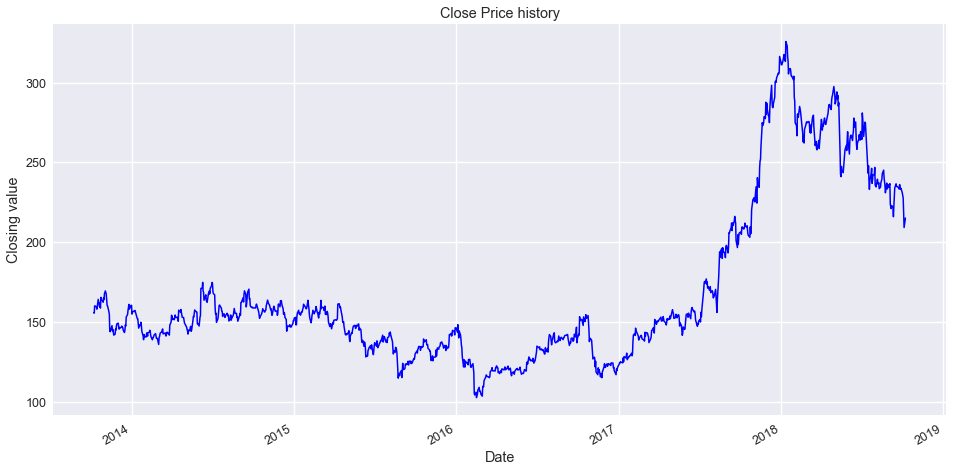

In [18]:
df["Close"].plot(figsize = (16,8),
                color = 'Blue')

plt.title('Close Price history')
plt.ylabel('Closing value')
plt.show()

### <span style = "color:orange">  Sort the dataset on date time and filter “Date” and “Close” </span>

In [27]:
#create new varaibles so the original df is not affected
data = df.sort_index(ascending = True, axis = 0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

#Fill the new data set: 
for i in range(0, len(data)):
    new_dataset["Date"][i] = data["Date"][i]
    new_dataset["Close"][i] = data["Close"][i]

In [28]:
new_dataset

Date   Close
0     2013-10-08 00:00:00   155.8
1     2013-10-09 00:00:00  155.55
2     2013-10-10 00:00:00  160.15
3     2013-10-11 00:00:00  160.05
4     2013-10-14 00:00:00  159.45
...                   ...     ...
1230  2018-10-01 00:00:00   230.9
1231  2018-10-03 00:00:00   227.6
1232  2018-10-04 00:00:00   218.2
1233  2018-10-05 00:00:00   209.2
1234  2018-10-08 00:00:00  215.15

[1235 rows x 2 columns]

### MinMaxScaler

In [36]:
#Using the dates as index (so they are not affected by the normalization)
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [42]:
#setting the normalization and the final_dataset that is only the closing prices
scaler = MinMaxScaler()
final_dataset = new_dataset.values
scaled_data = scaler.fit_transform(final_dataset)

## Separate the data

In [52]:
train_data=final_dataset[0:987,:] #this is so the test data is 20% of the whole dataset
valid_data=final_dataset[987:,:]

In [53]:
x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

# Build and train the LSTM model

In [73]:
lstm_model = Sequential() #define the neural network
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train_data.shape[1], 1))) #constructing the neurons
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dense(1)) #Dense so....


inputs_data = new_dataset[len(new_dataset) - len(valid_data)-60:].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)

lstm_model.compile(loss= 'mean_squared_error', optimizer = 'adam')
lstm_model.fit(x_train_data, y_train_data, epochs = 1, batch_size = 1, verbose= 2)

927/927 - 16s - loss: 0.0010


In [74]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

## Check the results

C:\Users\MSI\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


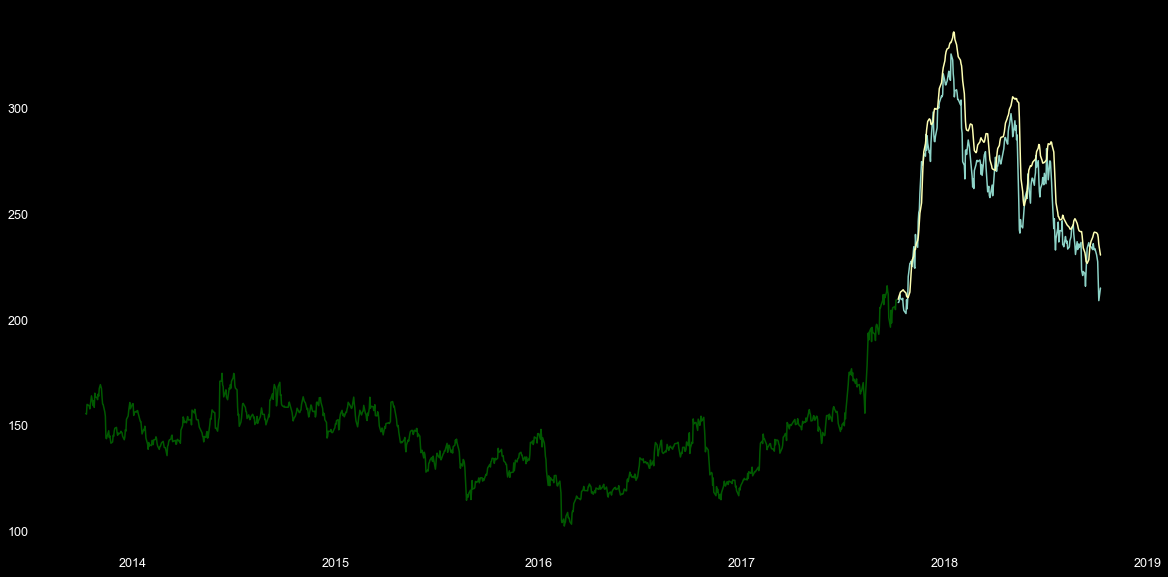

In [103]:
train_data = new_dataset[:987]
valid_data = new_dataset[987:]
valid_data['Predictions'] = predicted_closing_price

plt.plot(train_data["Close"],
        color = "green",
        alpha = 0.70)
plt.grid(False)
plt.plot(valid_data[['Close', "Predictions"]])

## Save the model

In [ ]:
lstm_model.save("saved_model.h5")